### Importação de Libs

In [1]:
import pandas as pd
import numpy as np
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [2]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import EnsembleVoteClassifier

In [3]:
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import plotly.express as px

### Making Functions and Most Important variables/constants

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
ID = test['PassengerId']
SEED = 4
IMPUTER = KNNImputer(weights='distance')
SCALER = MinMaxScaler()

In [5]:
def search_title(x):
    y = list(x)
    if y.index(','):
        y = y[y.index(',') + 2:y.index(" ", y.index(',') + 2)]
        return "".join(y)

In [6]:
def to_miss(x):
    arr = ['Mlle.', 'Mme.', 'Lady.', 'Ms.', 'Dona.']
    if x in arr:
        x = 'Miss.'
    return x

In [7]:
def to_mr(x):
    arr = ['Dr.', 'Rev.', 'Col.', 'Major.', 'Capt.', 'the.', 'Jonkheer.', 'Sir.', 'Don.', 'the' , 'Master.']
    if x in arr:
        x = 'Mr.'
    return x

In [8]:
def is_married(x):
    if x == 'Mrs.':
        return 1
    return 0

In [9]:
def is_alone(x):
    if x == 0:
        return 1
    return 0

In [10]:
def below_age(x):
    if x < 18:
        return 1
    return 0

##### Imputing Age

In [11]:
train[['Age']] = IMPUTER.fit_transform(train[['Age']])

##### Feature Engineering

In [12]:
train['Title'] = train['Name'].apply(search_title) #make a column of titles
train['Title'] = train['Title'].apply(to_miss) #separate titles that can go to Miss
train['Title'] = train['Title'].apply(to_mr) #separate titles that can go to Mr.

In [13]:
train['is_married'] = train['Title'].apply(is_married) #check if the person are married or not

In [14]:
train['below_age'] = train['Age'].apply(below_age) #check if the passanger is a child or not

In [15]:
train['family_size'] = train['SibSp'] + train['Parch'] #make a column about the family size on Titanic

In [16]:
train['is_alone'] = train['family_size'].apply(is_alone) #check if the passanger are alone

In [17]:
train['group_by_age'] = pd.qcut(train['Age'], q=4, labels=[1,2,3,4]).astype(int) #divide age by groups of Quantiles

In [18]:
train['group_by_fare'] = pd.qcut(train['Fare'], q=4, labels=[1,2,3,4]).astype(int) #divide fare by groups of Quantiles

##### Dropping NaN and Unwanted Columns

In [19]:
train.drop(columns=['PassengerId', 'Cabin', 'Ticket','Name'], inplace=True)

In [20]:
embarked_rows_to_drop = train[train[['Embarked']].isnull().any(axis=1)].index.values

In [21]:
train.drop(index=embarked_rows_to_drop, inplace=True)

### OneHotEncoding

In [22]:
ohe = OneHotEncoder(use_cat_names=True)
ohe_train = ohe.fit_transform(train)

c:\users\lucas\miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [23]:
X = ohe_train.drop(columns='Survived')
y = ohe_train['Survived']

### Scaling

In [24]:
X = SCALER.fit_transform(X)

In [25]:
X = pd.DataFrame(X, columns=ohe_train.columns[1:])

In [26]:
X

,Pclass,Sex_male,Sex_female,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q,Title_Mr.,Title_Mrs.,Title_Miss.,is_married,below_age,family_size,is_alone,group_by_age,group_by_fare
0,1.0,1.0,0.0,0.271174,0.125,0.000000,0.014151,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.1,0.0,0.000000,0.000000
1,0.0,0.0,1.0,0.472229,0.125,0.000000,0.139136,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.1,0.0,1.000000,1.000000
2,1.0,0.0,1.0,0.321438,0.000,0.000000,0.015469,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.333333,0.333333
3,0.0,0.0,1.0,0.434531,0.125,0.000000,0.103644,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.1,0.0,0.666667,1.000000
4,1.0,1.0,0.0,0.434531,0.000,0.000000,0.015713,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0.5,1.0,0.0,0.334004,0.000,0.000000,0.025374,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.333333
885,0.0,0.0,1.0,0.233476,0.000,0.000000,0.058556,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.666667
886,1.0,0.0,1.0,0.367921,0.125,0.333333,0.045771,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.3,0.0,0.333333,0.666667
887,0.0,1.0,0.0,0.321438,0.000,0.000000,0.058556,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667


#### Train Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
X, 
y, 
random_state=SEED,
test_size=0.20, 
stratify=y)

### Stacking Classifier

In [28]:
clf1 = LogisticRegression(random_state=SEED)
clf2 = RandomForestClassifier(random_state=SEED)
clf3= LGBMClassifier(random_state=SEED, subsample_freq=1)

labels = ['Logistic Regression', 'Random Forest Classifier', 'LGBMClassifier']

In [29]:
print('5-fold cross validation:')
for clf, label in zip([clf1, clf2, clf3], labels):

    scores = cross_val_score(clf, X, y, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

5-fold cross validation:
Accuracy: 0.79 (+/- 0.03) [Logistic Regression]
Accuracy: 0.80 (+/- 0.04) [Random Forest Classifier]
Accuracy: 0.83 (+/- 0.03) [LGBMClassifier]


In [30]:
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,2], voting='soft')

labels = ['Logistic Regression', 'Random Forest', 'LGBMClassifier', 'Ensemble']

for clf, label in zip([clf1, clf2, clf3, eclf], labels):

    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

Accuracy: 0.79 (+/- 0.03) [Logistic Regression]
Accuracy: 0.80 (+/- 0.04) [Random Forest]
Accuracy: 0.83 (+/- 0.03) [LGBMClassifier]
Accuracy: 0.84 (+/- 0.02) [Ensemble]


#### Tuning

In [31]:
def search_hyperparams(params):
    SEED = 4

    max_iter = params[0]
    C = params[1]
    n_estimators_random_forest = params[2]
    learning_rate = params[3]
    num_leaves = params[4]
    min_child_samples = params[5]
    subsample = params[6]
    colsample_bytree = params[7]
    n_estimators_lgbm = params[8]
    
    clf1 = LogisticRegression(random_state=SEED, 
                              max_iter=max_iter, 
                              C=C)
    
    clf2 = RandomForestClassifier(random_state=SEED, 
                                  n_estimators= n_estimators_random_forest)
    
    clf3= LGBMClassifier(random_state=SEED, 
                         subsample_freq=1, 
                         learning_rate=learning_rate,
                        num_leaves=num_leaves,
                        min_child_samples= min_child_samples,
                        subsample= subsample,
                        colsample_bytree = colsample_bytree,
                        n_estimators = n_estimators_lgbm)
 
    eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,2], voting='soft')
    
    scores = cross_val_score(eclf, X, y, cv=5, scoring='accuracy')
    
    return -scores.mean()

space = [
(100, 5000), #max_iter Logistic Regression
(1e-4, 1e-2, 'log-uniform'), #C Logistic Regression
(20, 200), #n_estimators RandomForest
(1e-3, 1e-1, 'log-uniform'), #learning rate LGBM
(2, 128), #num_leaves LGBM
(1, 100), #min_child_samples LGBM
(0.05, 1.0), #subsample LGBM
(0.1, 1.0), #colsample_bytree LGBM
(100, 1000)] #n_estimators LGBM

result = gp_minimize(search_hyperparams, 
space,
random_state=SEED, 
verbose=1,
n_calls = 30)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.2436
Function value obtained: -0.8279
Current minimum: -0.8279
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.3492
Function value obtained: -0.8223
Current minimum: -0.8279
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4997
Function value obtained: -0.8110
Current minimum: -0.8279
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.5985
Function value obtained: -0.7897
Current minimum: -0.8279
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0493
Function value obtained: -0.8020
Current minimum: -0.8279
Iteration No: 6 started. 

In [32]:
max_iter, C, n_estimators_random_forest, learning_rate, num_leaves, min_child_samples, subsample, colsample_bytree, n_estimators_lgbm = result.x

In [33]:
clf1 = LogisticRegression(random_state=SEED, 
                              max_iter=max_iter, 
                              C=C)
    
clf2 = RandomForestClassifier(random_state=SEED, 
                                  n_estimators= n_estimators_random_forest)
    
clf3= LGBMClassifier(random_state=SEED, 
                         subsample_freq=1, 
                         learning_rate=learning_rate,
                        num_leaves=num_leaves,
                        min_child_samples= min_child_samples,
                        subsample= subsample,
                        colsample_bytree = colsample_bytree,
                        n_estimators = n_estimators_lgbm)
 
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,2], voting='hard')

#### Validating

In [34]:
eclf.fit(X_train, y_train)

EnsembleVoteClassifier(clfs=[LogisticRegression(C=0.0001, max_iter=310,
                                                random_state=4),
                             RandomForestClassifier(n_estimators=25,
                                                    random_state=4),
                             LGBMClassifier(colsample_bytree=0.3700059027901569,
                                            learning_rate=0.003802615401944056,
                                            min_child_samples=9,
                                            n_estimators=379, num_leaves=65,
                                            random_state=4,
                                            subsample=0.45884544564953084,
                                            subsample_freq=1)],
                       weights=[1, 1, 2])

In [35]:
eclf.score(X_test, y_test)

0.7808988764044944

### Confusion Matrix

In [36]:
y_pred = eclf.predict(X_test)

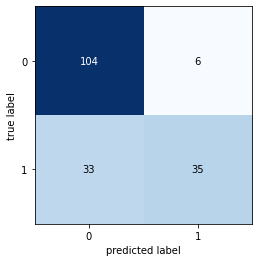

In [37]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm)

plt.show()


### Definitive Model

In [38]:
eclf.fit(X, y)

EnsembleVoteClassifier(clfs=[LogisticRegression(C=0.0001, max_iter=310,
                                                random_state=4),
                             RandomForestClassifier(n_estimators=25,
                                                    random_state=4),
                             LGBMClassifier(colsample_bytree=0.3700059027901569,
                                            learning_rate=0.003802615401944056,
                                            min_child_samples=9,
                                            n_estimators=379, num_leaves=65,
                                            random_state=4,
                                            subsample=0.45884544564953084,
                                            subsample_freq=1)],
                       weights=[1, 1, 2])

##### Imputing Age and Fare

In [39]:
test[['Age']] = IMPUTER.fit_transform(test[['Age']])
test[['Fare']] = IMPUTER.fit_transform(test[['Fare']])

##### Feature Engineering on Df Set

In [40]:
test['Title'] = test['Name'].apply(search_title) #make a column of titles
test['Title'] = test['Title'].apply(to_miss) #separate titles that can go to Miss
test['Title'] = test['Title'].apply(to_mr) #separate titles that can go to Mr.
test['is_married'] = test['Title'].apply(is_married) #check if the person are married or not
test['below_age'] = test['Age'].apply(below_age) #check if the passanger is a child or not
test['family_size'] = test['SibSp'] + test['Parch'] #make a column about the family size on Titanic
test['is_alone'] = test['family_size'].apply(is_alone) #check if the passanger are alone
test['group_by_age'] = pd.qcut(test['Age'], q=4, labels=[1,2,3,4]).astype(int) #divide age by groups of Quantiles
test['group_by_fare'] = pd.qcut(test['Fare'], q=4, labels=[1,2,3,4]).astype(int) #divide fare by groups of Quantiles

#### Dropping Unwanted Columns

In [41]:
test.drop(columns=['PassengerId', 'Ticket', 'Cabin', 'Name'], inplace=True)

#### OneHotEncoding, Scaling and Predicting

In [42]:
test = ohe.fit_transform(test)
test = SCALER.fit_transform(test)
result = eclf.predict(test)

c:\users\lucas\miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


#### Creating results.csv

In [43]:
sub = pd.Series(result, index=ID, name='Survived')
sub.to_csv("results.csv", header=True)